In [47]:
import pandas as pd
import numpy as np
import math

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from pycaret.regression import *
#from pycaret.time_series import * 

In [21]:
df = pd.read_csv(f"data/{'eth'}_daily.csv", parse_dates = ['time'])
pycaret_data = df.copy(deep = True)


# <center style="background-color:#2E86AB;color: white; vertical-align: middle; padding:10px 5px;\">Pycaret</center>

In [25]:
pycaret_data['Day'] = [i.day for i in pycaret_data['time']]
pycaret_data['Month'] = [i.month for i in pycaret_data['time']]
pycaret_data['Year'] = [i.year for i in pycaret_data['time']]
pycaret_data['Series'] = np.arange(1,len(pycaret_data)+1)
pycaret_data.rename(columns={'open': 'Label'},inplace=True)
pycaret_data = pycaret_data[['Series', 'Year', 'Month','Day', 'Label']]
pycaret_data.head()

,Series,Year,Month,Day,Label
0,1,2015,8,8,2.793760
1,2,2015,8,10,0.713989
2,3,2015,8,11,0.708087
3,4,2015,8,12,1.058750
4,5,2015,8,13,1.222240


In [26]:
train = pycaret_data[pycaret_data['Year'] < 2022]
test = pycaret_data[pycaret_data['Year'] >= 2022]
train.shape, test.shape

((2334, 5), (285, 5))

In [27]:
s = setup(
    data = train,
    test_data = test,
    target = 'Label',
    fold_strategy = 'timeseries',
    numeric_features = ['Year','Month','Day','Series'],
    fold = 5,
    transform_target = True,
    session_id = 123,
    silent=True
    )


,Description,Value
0,session_id,123
1,Target,Label
2,Original Data,"(2334, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2334, 4)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [29]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,512.7982,1125723.5350,611.8597,-1.1206,0.9892,0.4606,0.4460
knn,K Neighbors Regressor,512.9031,1122888.8052,611.2224,-1.1126,0.9894,0.4632,0.0120
dt,Decision Tree Regressor,516.9025,1127880.0793,615.2938,-1.2133,1.0018,0.4799,0.0100
gbr,Gradient Boosting Regressor,517.6098,1121989.6616,619.3629,-1.5503,1.0243,0.4980,0.0340
rf,Random Forest Regressor,523.9124,1135659.1603,626.8119,-1.8356,1.0437,0.5222,0.1120
lightgbm,Light Gradient Boosting Machine,533.0550,1166827.3139,637.5252,-2.5278,1.0666,0.5572,0.0460
ada,AdaBoost Regressor,573.1301,1280854.7230,672.9832,-3.7867,1.1542,0.6456,0.0360
et,Extra Trees Regressor,576.5299,1261788.5695,682.2520,-4.2680,1.2322,0.6536,0.0780
catboost,CatBoost Regressor,590.6450,1272475.8037,695.6585,-5.4073,1.3194,0.6918,0.6680
llar,Lasso Least Angle Regression,689.6875,1602306.9109,770.7293,-3.6168,2.3388,0.8056,0.0100


In [30]:
prediction_holdout = predict_model(best)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1668.1498,3377396.5000,1837.7694,-4.6518,0.7321,1.0157


In [31]:
xgb = create_model('xgboost')
xgb_tuned = tune_model(xgb) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,95.6701,24248.0918,155.7180,-0.5909,1.9152,0.5387
1,278.4441,139962.1250,374.1151,-1.0480,0.7551,0.4239
2,67.9833,7305.9224,85.4747,-1.6202,0.4516,0.4754
3,101.6524,20787.1230,144.1774,-0.4612,0.5024,0.3091
4,2071.3840,5546313.5000,2355.0613,-3.4051,1.5122,0.7181
Mean,523.0268,1147723.3524,622.9093,-1.4251,1.0273,0.4930
SD,777.7513,2199814.1657,871.6119,1.0701,0.5839,0.1354


In [14]:
lasso = create_model('lasso')
lasso_tuned = tune_model(lasso) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,911.6913,912828.0000,955.4203,-166.5575,1.4016,3.1042
1,817.6014,1528054.3750,1236.1450,-0.7380,1.0870,0.5303
2,5733.0518,44302072.0000,6655.9800,-3.3299,1.5173,0.7219
3,12131.1709,245066672.0000,15654.6055,-55.6308,0.9440,1.5340
4,15219.3291,355501024.0000,18854.7344,-0.1568,0.5284,0.3728
Mean,6962.5689,129462130.0750,8671.3770,-45.2826,1.0957,1.2527
SD,5844.2107,144639052.7908,7366.7732,64.1799,0.3511,1.0084


In [32]:
predictions = predict_model(xgb_tuned, data=pycaret_data)
predictions['Date'] = df['time']
predictions['Org Label'] = df['open']

In [33]:
fig = px.line(predictions, x='Date', y=["Label",'Org Label'], template = 'plotly_dark')
fig.show()

# <center style="background-color:#07de79;color: white; vertical-align: middle; padding:10px 5px;\">ARIMA</center>

In [34]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [35]:
result = adfuller(df.open.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.714322
p-value: 0.423749


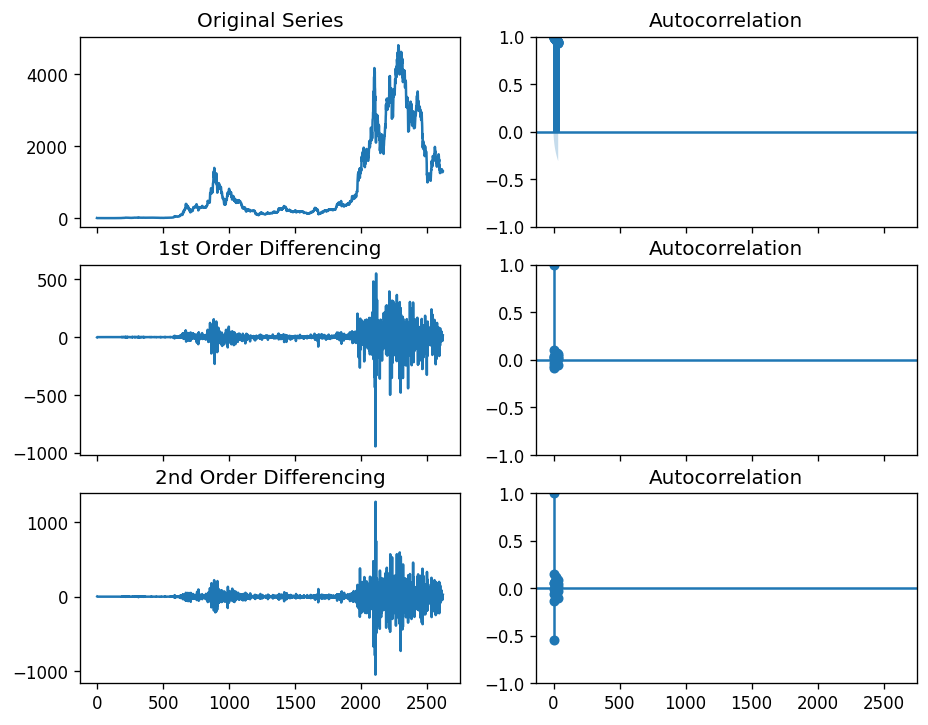

In [36]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.open); axes[0, 0].set_title('Original Series')
plot_acf(df.open, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.open.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.open.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.open.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.open.diff().diff().dropna(), ax=axes[2, 1])

plt.show()